<a href="https://colab.research.google.com/github/RuslanAgishev/trajectory_optimization/blob/master/notebooks/camera_traj_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if you are using Colab:
# from google.colab import drive
# drive.mount('/content/drive/')
# FE_PATH = "drive/MyDrive/CTU/trajectory_optimization/"

# if you are running locally
import rospkg
FE_PATH = rospkg.RosPack().get_path('trajectory_optimization')

In [7]:
import os
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from copy import deepcopy

### Helper functions

In [8]:
def set_axis_equal(ax, x_limits=None, y_limits=None, z_limits=None):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    if x_limits is None:
        x_limits = ax.get_xlim3d()
    if y_limits is None:
        y_limits = ax.get_ylim3d()
    if z_limits is None:
        z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def load_intrinsics(device=torch.device('cuda')):
    width, height = 1232., 1616.
    K = torch.tensor([[758.03967, 0., 621.46572, 0.],
                      [0., 761.62359, 756.86402, 0.],
                      [0., 0., 1., 0.],
                      [0., 0., 0., 1.]], dtype=torch.float32).to(device)
    K = K.unsqueeze(0)
    return K, width, height


def curvature_calc(traj_wps):
        """
        Calculates average trajectory curvature
        References:
            - https://en.wikipedia.org/wiki/Menger_curvature#Definition
            - https://math.stackexchange.com/questions/128991/how-to-calculate-the-area-of-a-3d-triangle
        """
        # computing curvature at i-th waypoint (i.e. traj_wps[i])
        K_traj = torch.zeros(len(traj_wps)-2)
        for i in range(1, len(traj_wps)-1):
            p1, p2, p3 = torch.as_tensor(traj_wps[i-1]), torch.as_tensor(traj_wps[i]), torch.as_tensor(traj_wps[i+1])

            AB = p1 - p2
            AC = p3 - p2

            # area of the triangle
            S = 0.5 * torch.sqrt((AB[1]*AC[2] - AB[2]*AC[1])**2 + (AB[2]*AC[0] - AB[0]*AC[2])**2 + (AB[0]*AC[1] - AB[1]*AC[0])**2)
            
            # curvature
            k = 4*S / (torch.linalg.norm(p1-p2) * torch.linalg.norm(p2-p3) * torch.linalg.norm(p3-p1))
            K_traj[i-1] = k
        return torch.mean(K_traj)

### Define model to optimize trajectory

In [9]:
class Model(nn.Module):
    def __init__(self,
                 points: torch.tensor,
                 traj_wps: list,  # [np.array([x0, y0, z0]), np.array([x1, y1, z1]), ...]
                 min_dist=1.0, max_dist=10.0,
                 dist_rewards_mean=3.0, dist_rewards_sigma=2.0):
        super().__init__()
        self.points = points
        self.rewards = None
        self.observations = None
        self.device = points.device
        self.lo_sum = 0.0  # log odds sum for the entire point cloud for the whole trajectory

        # Create an optimizable parameter for the x, y, z position of the camera.
        self.rot0 = torch.eye(3, device=self.device).unsqueeze(0)
        for i in range(len(traj_wps) - 1):
            self.rot0 = torch.cat([self.rot0, torch.eye(3, device=self.device).unsqueeze(0)])  # (N, 3, 3)
        self.traj0 = torch.from_numpy(np.array(traj_wps, dtype=np.float32)).to(self.device)  # (N, 3)

        self.traj = nn.Parameter(deepcopy(self.traj0))
        self.rots = nn.Parameter(self.rot0)

        self.K, self.width, self.height = load_intrinsics(device=self.device)
        self.eps = 1e-6
        self.pc_clip_limits = [min_dist, max_dist]  # [m]
        self.dist_rewards = {'mean': dist_rewards_mean, 'dist_rewards_sigma': dist_rewards_sigma}
        
        self.loss = {'vis': float('inf'),
                     'length': float('inf'),
                     'l2': float('inf'),
                     'smooth': float('inf')}

    @staticmethod
    def get_dist_mask(points, min_dist=1.0, max_dist=5.0):
        # clip points between MIN_DIST and MAX_DIST meters distance from the camera
        dist_mask = (points[2] > min_dist) & (points[2] < max_dist)
        return dist_mask

    @staticmethod
    def get_fov_mask(points, img_height, img_width, intrins):
        # find points that are observed by the camera (in its FOV)
        pts_homo = intrins[:3, :3] @ points
        pts_homo[:2] /= pts_homo[2:3]
        fov_mask = (pts_homo[2] > 0) & (pts_homo[0] > 1) & \
                   (pts_homo[0] < img_width - 1) & (pts_homo[1] > 1) & \
                   (pts_homo[1] < img_height - 1)
        return fov_mask

    def to_camera_frame(self, verts, R, T):
        R_inv = torch.transpose(torch.squeeze(R, 0), 0, 1)
        verts = torch.transpose(verts - torch.repeat_interleave(T, len(verts), dim=0).to(self.device), 0, 1)
        verts = torch.matmul(R_inv, verts)
        verts = torch.transpose(verts, 0, 1)
        return verts

    @staticmethod
    def gaussian(x, mu=3.0, sigma=100.0, normalize=False):
        # https://en.wikipedia.org/wiki/Normal_distribution
        g = torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
        if normalize:
            g /= (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
        return g

    def distance_visibility(self, verts, pose):
        # compute observations based on distance of the surrounding points
        dists = torch.linalg.norm(pose - verts, dim=1)
        rewards = self.gaussian(dists, mu=self.dist_rewards['mean'], sigma=self.dist_rewards['dist_rewards_sigma'])
        return rewards

    def forward(self):
        """
        Trajectory evaluation based on visibility estimation from its waypoints.
        traj_score = log_odds_sum([visibility_estimation(wp) for wp in traj_waypoints])
        """
        N_wps = self.traj.size()[0]
        lo_sum = 0.0
        for i in range(N_wps):
            # transform points to camera frame
            verts = self.to_camera_frame(self.points, self.rots[i].unsqueeze(0), self.traj[i].unsqueeze(0))
            verts = torch.transpose(verts, 0, 1)

            # get masks of points that are inside of the camera FOV
            dist_mask = self.get_dist_mask(verts, self.pc_clip_limits[0], self.pc_clip_limits[1])
            fov_mask = self.get_fov_mask(verts, self.height, self.width, self.K.squeeze(0))

            mask = torch.logical_and(dist_mask, fov_mask)

            p = self.distance_visibility(self.points,
                                         self.traj[i].unsqueeze(0)) * mask  # local observations reward (visibility)

            # apply log odds conversion for global voxel map observations update
            p = torch.clip(p, 0.5, 1.0 - self.eps)
            lo = torch.log(p / (1.0 - p))
            lo_sum = lo_sum + lo

        self.rewards = 1.0 / (1.0 + torch.exp(-lo_sum))  # total trajectory observations
        loss = self.criterion(self.rewards)
        return loss

    @staticmethod
    def length_calc(traj):
        l = 0.0
        for i in range(len(traj)-1):
            l += torch.linalg.norm(traj[i+1] - traj[i])
        return l

    def angle_calc(self, traj_wps):
        phis = torch.zeros(len(traj_wps)-2)
        for i in range(1, len(traj_wps)-1):
            p1, p2, p3 = torch.as_tensor(traj_wps[i-1]), torch.as_tensor(traj_wps[i]), torch.as_tensor(traj_wps[i+1])

            AB = p1 - p2
            AC = p3 - p2

            phi = torch.arccos(torch.dot(AB, AC) / (torch.linalg.norm(AB) * torch.linalg.norm(AC) + self.eps))
            phis[i-1] = phi
        return torch.mean(phis)

    def criterion(self, rewards):
        # transform observations to loss function: loss = N_points / sum(prob(observed))
        self.loss['vis'] = len(self.points) / (torch.sum(rewards) + self.eps)

        # penalties for being far from initial waypoints
        self.loss['l2'] = torch.linalg.norm(self.traj[0] - self.traj0[0])
        # for i in range(1, len(self.traj)):
        #     self.loss['l2'] += 0.0003*torch.linalg.norm(self.traj[i] - self.traj0[i])

        # smoothness estimation based on average angles between waypoints:
        # the bigger the angle the better
        self.loss['smooth']  = 0.05 / (self.angle_calc(self.traj) + self.eps)

        # penalty for trajectory length (compared to initial one)
        self.loss['length'] = 0.0005 * torch.abs(self.length_calc(self.traj) - self.length_calc(self.traj0))

        return self.loss['vis'] + self.loss['l2'] + self.loss['length'] + self.loss['smooth']

### Load point cloud

In [13]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# Set paths
# index = 1612893730.3432848
index = np.random.choice(os.listdir(os.path.join(FE_PATH, "data/points/")))[12:-4]
points_filename = os.path.join(FE_PATH, f"data/points/point_cloud_{index}.npz")
pts_np = np.load(points_filename)['pts'].transpose()

# make sure the point cloud is of (N x 3) shape:
if pts_np.shape[1] > pts_np.shape[0]:
    pts_np = pts_np.transpose()
points = torch.tensor(pts_np, dtype=torch.float32).to(device)

poses_filename = os.path.join(FE_PATH, f"data/paths/path_poses_{index}.npz")
traj_wps = np.load(poses_filename)['poses'].tolist()

### Define the model

In [14]:
# Initialize a model
model = Model(points=points,
              traj_wps=traj_wps).to(device)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Optimization loop

In [15]:
!nvidia-smi

Thu Apr  8 15:32:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.181.07   Driver Version: 418.181.07   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    20W /  N/A |    850MiB /  5914MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

  0%|          | 0/501 [00:00<?, ?it/s]

vis loss: 1.8742777109146118
length loss: 0.0
l2 loss: 0.0
smooth loss: 0.019191978499293327
Trajectory visibility score: 0.5335388779640198

-----------------------------------

Optimization step took 0.2997853755950928 sec


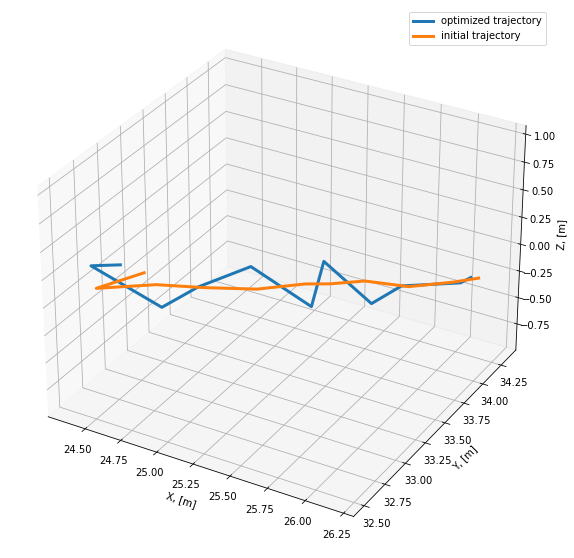

vis loss: 1.8363733291625977
length loss: 0.0027412609197199345
l2 loss: 0.014962590299546719
smooth loss: 0.01804783008992672
Trajectory visibility score: 0.5445515513420105

-----------------------------------

Optimization step took 0.023931264877319336 sec


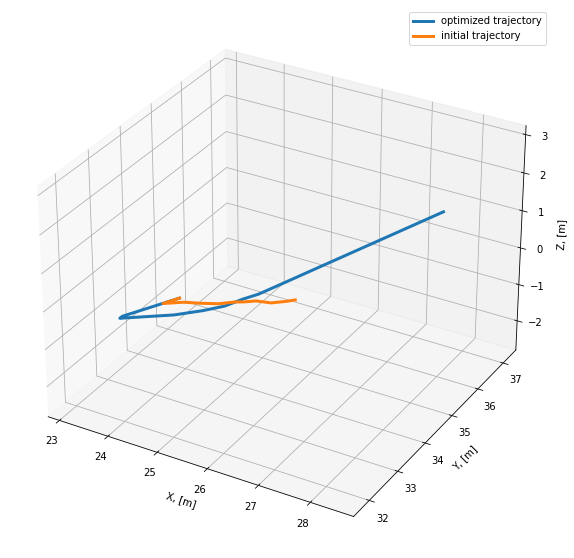

vis loss: 1.822313904762268
length loss: 0.00327697885222733
l2 loss: 0.007717922329902649
smooth loss: 0.018132446333765984
Trajectory visibility score: 0.5487528443336487

-----------------------------------

Optimization step took 0.03398323059082031 sec


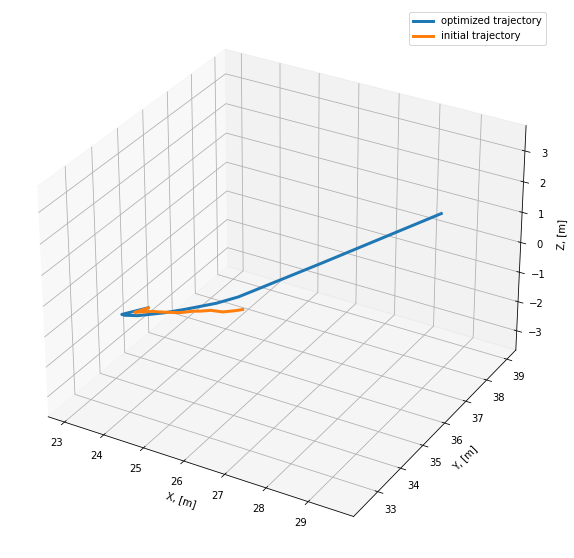

vis loss: 1.8371392488479614
length loss: 0.0027962010353803635
l2 loss: 0.016095740720629692
smooth loss: 0.018054479733109474
Trajectory visibility score: 0.5443245768547058

-----------------------------------

Optimization step took 0.033402442932128906 sec


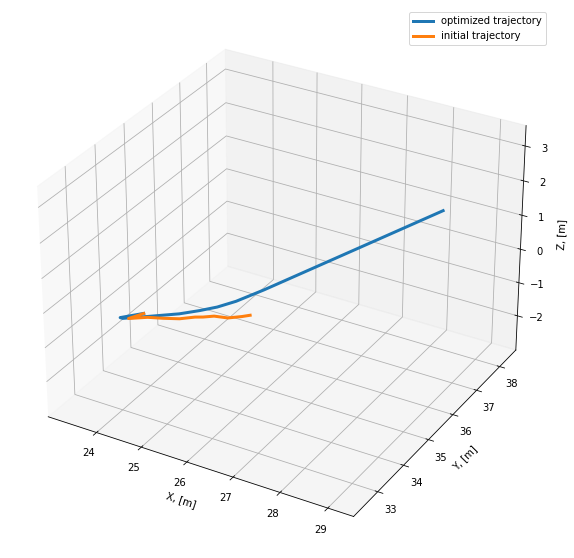

vis loss: 1.8493046760559082
length loss: 0.0016421981854364276
l2 loss: 0.013208447024226189
smooth loss: 0.01655777357518673
Trajectory visibility score: 0.5407438278198242

-----------------------------------

Optimization step took 0.02807784080505371 sec


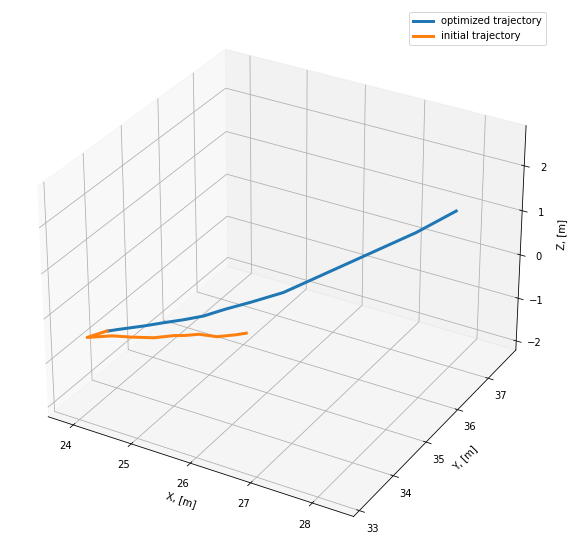

vis loss: 1.8513593673706055
length loss: 0.0013398664304986596
l2 loss: 0.008093111217021942
smooth loss: 0.016525262966752052
Trajectory visibility score: 0.540143609046936

-----------------------------------

Optimization step took 0.02925562858581543 sec


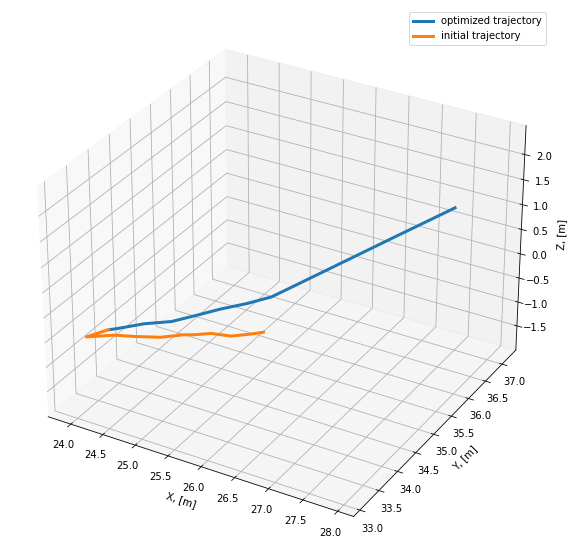

Average optimization step runtime: 0.0747392972310384


In [16]:
import time

log = {'rewards': [], 'runtime': []}
for key in model.loss:
    log[key] = []

# Run optimization loop
traj_0 = np.asarray(traj_wps)

loop = tqdm(range(501))
for i in loop:
    t0 = time.time()
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    t1 = time.time()

    if i % 100 == 0:
        for key in model.loss:
            print(f"{key} loss: {model.loss[key]}")
            log[key].append(model.loss[key])  # logging losses
        log['rewards'].append(torch.sum(model.rewards) / len(model.points))  # logging visibility reward
        log['runtime'].append(t1 - t0)

        print(f"Trajectory visibility score: {log['rewards'][-1]}")
        print("\n-----------------------------------\n")
        print(f"Optimization step took {log['runtime'][-1]} sec")
        
        traj = model.traj.detach().cpu().numpy()

        # plt.figure(figsize=(10, 10))
        # plt.grid()
        # plt.plot(traj[:, 0], traj[:, 1], label='optimized trajectory')
        # plt.plot(traj_0[:, 0], traj_0[:, 1], label='initial trajectory')
        # plt.axis('equal')
        # plt.legend()
        # plt.show();

        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        set_axis_equal(ax, x_limits=[np.min(traj[:,0]), np.max(traj[:,0])],
                           y_limits=[np.min(traj[:,1]), np.max(traj[:,1])],
                           z_limits=[np.min(traj[:,2]), np.max(traj[:,2])])
        ax.set_xlabel('X, [m]')
        ax.set_ylabel('Y, [m]')
        ax.set_zlabel('Z, [m]')
        ax.plot(traj[:,0], traj[:,1], traj[:,2], linewidth=3, label='optimized trajectory')
        ax.plot(traj_0[:,0], traj_0[:,1], traj_0[:,2], linewidth=3, label='initial trajectory')
        ax.legend()
        plt.show()

print(f"Average optimization step runtime: {np.mean(log['runtime'])}")

# Losses

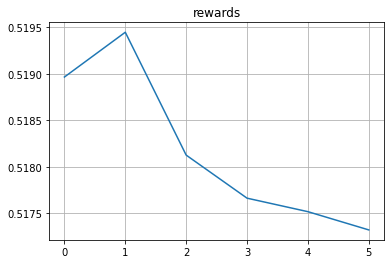

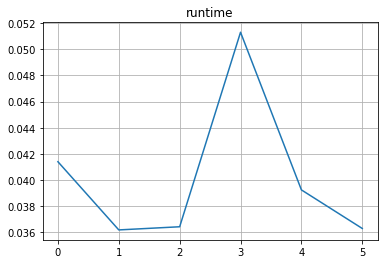

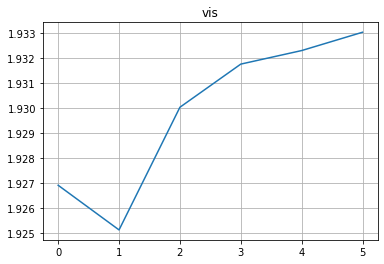

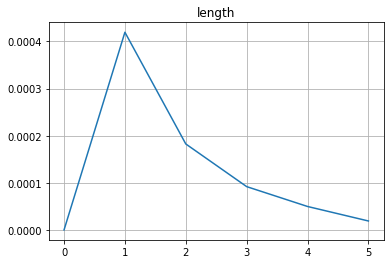

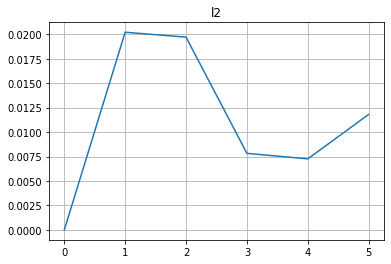

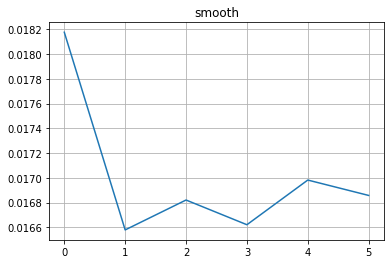

In [9]:
for key in log:
    plt.figure()
    plt.title(f"{key}")
    plt.plot(log[key])
    plt.grid()
    plt.show()